Loading test dataset...
Rounding threshold column in test data...
Test data shape: (101, 17)

Loading Keras model from: models/lstm_model_4.keras


/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_70 (LSTM)                  │ (None, 99, 14)         │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 99, 7)          │           616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 99, 1)          │             8 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,714 (14.51 KB)

 Trainable params: 1,856 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,858 (7.26 KB)

Loading X dynamic scaler from: scalers/x_dynamic_scaler.pkl
Loading Y accuracy scaler from: scalers/y_acc_scaler.pkl

Preparing test sequences...
From test DataFrame, prepared 1 sequences, skipped 0 models.

Performing auto-regressive prediction on the test set...
Predicting for test model_id: 0 (1/1)
Model ID: 0, MAE: 0.0422

--- Test Set Benchmark Results (Model with acc_10) ---
Mean Absolute Error (MAE) on Test Set: 0.0422

Visualizing predictions for 1 test samples...


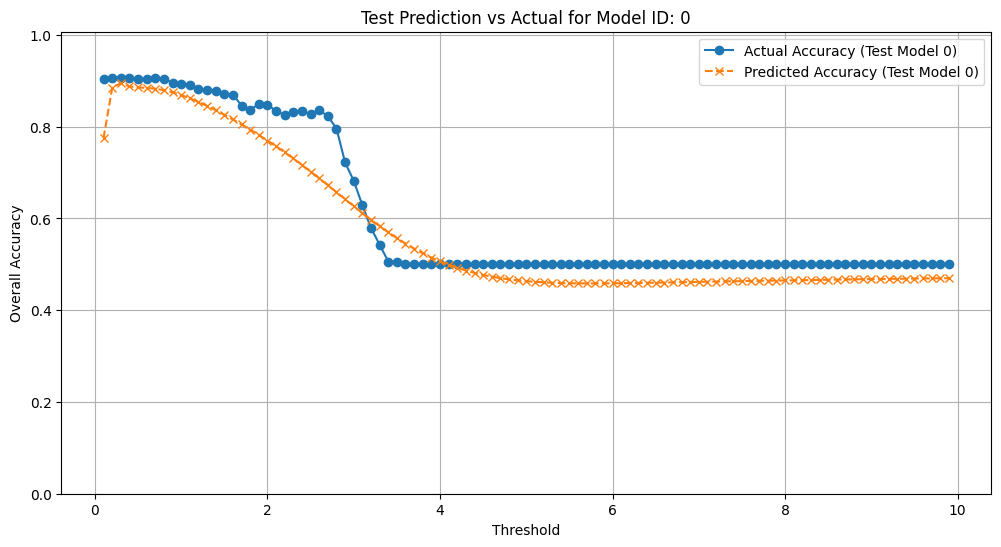


Benchmark script finished.


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle # For loading scikit-learn scalers
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# --- Configuration ---
DATASET_PATH = Path("generalize")
MODEL_FILE_PATH = Path("models/lstm_model_4.keras") # UPDATE with your model file name
X_SCALER_PATH = Path("scalers/x_dynamic_scaler.pkl") # UPDATE for scalers used with this model
Y_SCALER_PATH = Path("scalers/y_acc_scaler.pkl")   # UPDATE for scalers used with this model

# Feature and sequence configurations (MUST match how the model was trained)
dynamic_feature_cols = ['flops', 'non_zero_params', 'params_reduction_pct', 'flops_reduction_pct']
target_col = 'overall_accuracy'
INTERMEDIATE_THRESHOLDS = np.round(np.arange(0.1, 10.0, 0.1), 1) # 99 points
SEQUENCE_LENGTH = len(INTERMEDIATE_THRESHOLDS) # Should be 99

# Based on model trained WITH acc_10:
# num_dynamic_features = len(dynamic_feature_cols) # 4
# num_acc_like_features_in_X = 3 # acc_0_feat, acc_10_feat, lagged_acc_feat
# n_features_per_step = num_dynamic_features + num_acc_like_features_in_X # 4 + 3 = 7

# --- Helper Function to Prepare Sequences from DataFrame (WITH acc_10 input) ---
# This function is needed to process the test data in the same way as training/validation
def prepare_sequences_for_test_with_acc10(df, dynamic_cols, target_col_name, intermediate_thresholds_list):
    X_list_local = []
    y_list_local = []
    processed_model_info_local = [] # Stores model_id, acc_0, acc_10 for each sample
    skipped_count_local = 0

    for model_id, group in df.groupby('model_id'):
        group = group.sort_values(by='threshold').reset_index(drop=True)
        acc_at_0_series = group[group['threshold'] == 0.0][target_col_name]
        acc_at_10_series = group[group['threshold'] == 10.0][target_col_name]

        if acc_at_0_series.empty or acc_at_10_series.empty:
            print(f"Warning: Skipping model_id {model_id} in test set due to missing boundary data.")
            skipped_count_local += 1
            continue
        
        acc_0_val = acc_at_0_series.iloc[0]
        acc_10_val = acc_at_10_series.iloc[0]

        intermediate_data = group[group['threshold'].isin(intermediate_thresholds_list)].copy()
        if len(intermediate_data) != len(intermediate_thresholds_list):
            print(f"Warning: Skipping model_id {model_id} in test set. Expected {len(intermediate_thresholds_list)} intermediate points, found {len(intermediate_data)}.")
            skipped_count_local += 1
            continue
        intermediate_data = intermediate_data.sort_values(by='threshold').reset_index(drop=True)

        current_dynamic_features = intermediate_data[dynamic_cols].values
        acc_0_feature_repeated = np.tile(acc_0_val, (len(intermediate_thresholds_list), 1))
        acc_10_feature_repeated = np.tile(acc_10_val, (len(intermediate_thresholds_list), 1))

        lagged_accuracies = np.zeros((len(intermediate_thresholds_list), 1))
        lagged_accuracies[0] = acc_0_val
        if len(intermediate_thresholds_list) > 1:
            lagged_accuracies[1:] = intermediate_data[target_col_name].values[:-1].reshape(-1,1) # Using actual for lagged input construction

        model_X_sample = np.concatenate([
            current_dynamic_features,
            acc_0_feature_repeated,
            acc_10_feature_repeated,
            lagged_accuracies
        ], axis=1)
        X_list_local.append(model_X_sample)

        model_y_sample = intermediate_data[target_col_name].values.reshape(-1, 1)
        y_list_local.append(model_y_sample)
        
        processed_model_info_local.append({
            'model_id': model_id,
            'acc_0': acc_0_val,
            'acc_10': acc_10_val,
            'dynamic_features': current_dynamic_features # Store unscaled dynamic features for prediction
        })
        
    if not X_list_local and not df.empty:
        raise ValueError(f"No valid sequences prepared from the provided test DataFrame. Skipped {skipped_count_local} models.")
    
    print(f"From test DataFrame, prepared {len(X_list_local)} sequences, skipped {skipped_count_local} models.")
    return np.array(X_list_local), np.array(y_list_local), processed_model_info_local


# --- Auto-Regressive Prediction Function (WITH acc_10 input) ---
def predict_auto_regressively_with_acc10(model_to_use,
                                         unscaled_dynamic_features_sample,
                                         unscaled_acc_0,
                                         unscaled_acc_10,
                                         x_dynamic_scaler_model, y_acc_scaler_model,
                                         seq_len, num_dyn_feat):
    scaled_dynamic_features = x_dynamic_scaler_model.transform(unscaled_dynamic_features_sample)
    scaled_acc_0_val = y_acc_scaler_model.transform(np.array([[unscaled_acc_0]]))[0,0]
    scaled_acc_10_val = y_acc_scaler_model.transform(np.array([[unscaled_acc_10]]))[0,0]

    scaled_acc_0_feat_repeated = np.tile(scaled_acc_0_val, (seq_len, 1))
    scaled_acc_10_feat_repeated = np.tile(scaled_acc_10_val, (seq_len, 1))

    current_input_X = np.zeros((1, seq_len, num_dyn_feat + 3)) # dyn + acc0 + acc10 + lagged
    current_input_X[0, :, :num_dyn_feat] = scaled_dynamic_features
    current_input_X[0, :, num_dyn_feat] = scaled_acc_0_feat_repeated[:,0]
    current_input_X[0, :, num_dyn_feat + 1] = scaled_acc_10_feat_repeated[:,0]

    last_predicted_acc_scaled = scaled_acc_0_val
    generated_sequence_scaled = np.zeros(seq_len)

    for t in range(seq_len):
        current_input_X[0, t, num_dyn_feat + 2] = last_predicted_acc_scaled
        prediction_all_steps_scaled = model_to_use.predict(current_input_X, verbose=0)
        current_step_pred_scaled = prediction_all_steps_scaled[0, t, 0]
        generated_sequence_scaled[t] = current_step_pred_scaled
        last_predicted_acc_scaled = current_step_pred_scaled
        
    return y_acc_scaler_model.inverse_transform(generated_sequence_scaled.reshape(-1,1)).flatten()

# --- Main Script ---
if __name__ == "__main__":
    # 1. Load Test Data
    print("Loading test dataset...")
    try:
        test_df_raw = pd.read_csv(DATASET_PATH / "cats_vs_dogs/pruning_results.csv")
    except FileNotFoundError:
        print(f"Error: Test dataset '{DATASET_PATH / 'test_dataset.csv'}' not found.")
        exit()

    print("Rounding threshold column in test data...")
    test_df = test_df_raw.copy()
    test_df['threshold'] = test_df['threshold'].round(1)
    print(f"Test data shape: {test_df.shape}")

    # Add a model_id column if it doesn't exist
    if 'model_id' not in test_df.columns:
        test_df['model_id'] = 0

    if test_df.empty:
        print("Test data is empty. No benchmark to run.")
        exit()

    # 2. Load Model and Scalers
    print(f"\nLoading Keras model from: {MODEL_FILE_PATH}")
    try:
        model = load_model(MODEL_FILE_PATH)
        model.summary()
    except Exception as e:
        print(f"Error loading Keras model: {e}")
        exit()

    print(f"Loading X dynamic scaler from: {X_SCALER_PATH}")
    try:
        with open(X_SCALER_PATH, 'rb') as f:
            x_dynamic_scaler = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: X dynamic scaler file '{X_SCALER_PATH}' not found.")
        exit()
    except Exception as e:
        print(f"Error loading X dynamic scaler: {e}")
        exit()

    print(f"Loading Y accuracy scaler from: {Y_SCALER_PATH}")
    try:
        with open(Y_SCALER_PATH, 'rb') as f:
            y_acc_scaler = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: Y accuracy scaler file '{Y_SCALER_PATH}' not found.")
        exit()
    except Exception as e:
        print(f"Error loading Y accuracy scaler: {e}")
        exit()

    # 3. Prepare Test Sequences (using the same logic as training)
    # Note: The X_test_all_samples created here is primarily for getting unscaled features.
    # The y_test_all_samples is the ground truth.
    # The processed_test_model_info contains unscaled acc_0, acc_10, and dynamic_features per model_id.
    print("\nPreparing test sequences...")
    _, y_test_all_samples, processed_test_model_info = \
        prepare_sequences_for_test_with_acc10(test_df, dynamic_feature_cols, target_col, INTERMEDIATE_THRESHOLDS)

    if not processed_test_model_info: # Checks if any models were successfully processed
        print("No valid test samples could be prepared. Exiting.")
        exit()
        
    # Determine num_dynamic_features from the first processed sample if available
    # This assumes all samples have the same number of dynamic features
    num_dynamic_features = processed_test_model_info[0]['dynamic_features'].shape[1]


    # 4. Perform Auto-Regressive Prediction on Test Set
    print("\nPerforming auto-regressive prediction on the test set...")
    all_test_predictions = []
    all_test_actuals = [] # Will be populated from y_test_all_samples

    for idx, model_info in enumerate(processed_test_model_info):
        model_id = model_info['model_id']
        unscaled_dyn_features = model_info['dynamic_features'] # Already (seq_len, num_dyn_features)
        unscaled_acc0 = model_info['acc_0']
        unscaled_acc10 = model_info['acc_10']

        model_predictions = []
        model_actuals = []
        
        print(f"Predicting for test model_id: {model_id} ({idx+1}/{len(processed_test_model_info)})")

        predicted_curve = predict_auto_regressively_with_acc10(
            model,
            unscaled_dyn_features,
            unscaled_acc0,
            unscaled_acc10,
            x_dynamic_scaler, y_acc_scaler,
            SEQUENCE_LENGTH, num_dynamic_features
        )

        # Append the predicted curve for this model
        model_predictions.append(predicted_curve)
        model_actuals.append(y_test_all_samples[idx].flatten()) # y_test_all_samples should align with processed_test_model_info

        mae = mean_absolute_error(model_actuals[0], model_predictions[0])
        print(f"Model ID: {model_id}, MAE: {mae:.4f}")

        all_test_predictions.append(predicted_curve)
        all_test_actuals.append(y_test_all_samples[idx].flatten()) # y_test_all_samples should align with processed_test_model_info

    if not all_test_predictions:
        print("No predictions were made. Cannot evaluate.")
        exit()

    all_test_predictions_np = np.array(all_test_predictions)
    all_test_actuals_np = np.array(all_test_actuals)

    # 5. Evaluate Model
    test_mae = mean_absolute_error(all_test_actuals_np.flatten(), all_test_predictions_np.flatten())
    print(f"\n--- Test Set Benchmark Results (Model with acc_10) ---")
    print(f"Mean Absolute Error (MAE) on Test Set: {test_mae:.4f}")

    # 6. Visualize Predictions for a few Test Samples
    num_samples_to_plot = min(3, len(processed_test_model_info))
    print(f"\nVisualizing predictions for {num_samples_to_plot} test samples...")

    for i in range(num_samples_to_plot):
        model_info_plot = processed_test_model_info[i]
        model_id_plot = model_info_plot['model_id']
        acc0_plot = model_info_plot['acc_0']
        acc10_plot = model_info_plot['acc_10'] # This was an input

        plt.figure(figsize=(12, 6))
        plt.plot(INTERMEDIATE_THRESHOLDS, all_test_actuals_np[i], label=f'Actual Accuracy (Test Model {model_id_plot})', marker='o', linestyle='-')
        plt.plot(INTERMEDIATE_THRESHOLDS, all_test_predictions_np[i], label=f'Predicted Accuracy (Test Model {model_id_plot})', marker='x', linestyle='--')

        plt.title(f"Test Prediction vs Actual for Model ID: {model_id_plot}")
        plt.xlabel("Threshold")
        plt.ylabel("Overall Accuracy")
        plt.legend()
        plt.grid(True)
        min_val_plot = min(0, np.min(all_test_actuals_np[i]) - 0.1, np.min(all_test_predictions_np[i]) - 0.1 if len(all_test_predictions_np[i]) > 0 else 0)
        max_val_plot = max(1, np.max(all_test_actuals_np[i]) + 0.1, np.max(all_test_predictions_np[i]) + 0.1 if len(all_test_predictions_np[i]) > 0 else 1)
        plt.ylim(min_val_plot, max_val_plot)
        plt.show()

    print("\nBenchmark script finished.")